In [1]:
# ! mkdir -p ~/aiffel/songys_chatbot

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("슝=3")

슝=3


In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


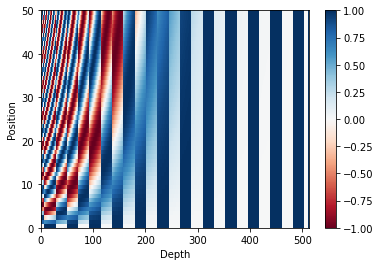

In [4]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터' 입니다.

단, 여기서 '단어 벡터' 란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터 입니다.

그럼 위 세 가지 어텐션이 하는 일을 조금 더 자세히 알아보겠습니다.

    인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
    디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
    인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

15-5. 스케일드 닷 프로덕트 어텐션

앞서 어텐션이 단어들 간의 유사도를 구하는 메커니즘이라고 했었죠?

그렇다면 유사도를 구하는 방법이 있을 겁니다.

트랜스포머에서는 어텐션 값을 구하는 방법으로 아래와 같은 수식을 사용했습니다.
Attention(Q,K,V)=softmax(QKT√dk)V

QQQ, KKK, VVV는 각각 쿼리(Query), 키(Key), 값(Value)를 나타냅니다.

앞서 언급했던 어텐션 함수의 정의와 결괏값을 다시 상기해봅시다.

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해 줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 합니다.

위 정의와 아래 내용 세 가지만 기억하면 수식을 그림으로 정리할 수 있습니다.

    Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
    벡터의 내적(dot product) 은 벡터의 유사도를 의미한다.
    특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.

우선 QQQ와 KKK의 전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같습니다.
content img

문장 행렬 QQQ와 문장 행렬 KKK를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있습니다.

위 초록색 행렬이 의미하는 값은 무엇일까요? 예를 들어 'am' 행과 'student' 열의 값은 QQQ 행렬에 있던 'am' 벡터와 KKK 행렬에 있던 'student 벡터'의 내적값을 의미합니다. 결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것이지요!

이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용합니다. 여기까지가 QQQ와 KKK의 유사도를 구하는 과정이라고 볼 수 있겠습니다. 여기에 문장 행렬 VVV와 곱하면 어텐션 값(Attention Value) 를 얻습니다.
content img

결국 이를 모두 하나의 그림으로 표현하면 위와 같습니다.
Attention(Q,K,V)=softmax(QKT√dk)V

이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 QQQ와 KKK의 유사도를 구하였다고 하여 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention) 이라고 합니다. 유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙은 것이지요.

만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 무엇일까요? 그 어텐션은 당연히 닷 프로덕트 어텐션(dot product attention) 이라고 부릅니다.

In [5]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


## 15-7. 마스킹

마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법입니다.

트랜스포머에서는 어텐션을 위해서 크게 두 가지 마스킹을 사용한다고 하는데요.
패딩 마스킹(Padding Masking)

첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법입니다.

In [7]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [8]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다릅니다.

RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있습니다. 그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요합니다.

In [9]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [11]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 15-8. 인코더
하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.
바로 셀프 어텐션과 피드 포워드 신경망입니다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다. 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.

In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


##### 인코더 층을 쌓아 인코더 만들기

이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다. 위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [13]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## 15-9. 디코더

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡합니다. 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다릅니다.

첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행합니다.

In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#### 디코더 층을 쌓아 디코더 만들기

이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


## 15-10. 챗봇의 병렬 데이터 받아오기

여기서는 Cornell Movie-Dialogs Corpus라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용합니다. 대화의 쌍이라고 하는 것은 기본적으로 먼저 말하는 사람의 대화 문장이 있고, 그에 응답하는 대화 문장의 쌍으로 이루어집니다.

데이터를 받아오는 이번 스텝에서 목표로 하는 것은 다음과 같습니다.

    정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.
    문장에서 단어와 구두점 사이에 공백을 추가한다.
    알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

#이전 데이터 불러오기
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')
print("슝=3")

#질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
#이거를 손을 봐야 돌아갈 것 같다
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs
print("슝=3")

[판다스iterrow](https://dschloe.github.io/python/pandas/iterrows/#iii-data-frame%EA%B3%BC-for-loop%EC%9D%98-%EC%8B%A4%EC%B2%B4)   
판다스는 무슨 형태로 뽑아내느냐가 참 중요한데 아직 잘 터진다

In [17]:
path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(path)
data.head()
# 질문이 Q(uestion) 답변이 A(nswer)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [18]:
data.dtypes
#목표값이 오브젝트임을 확인

Q        object
A        object
label     int64
dtype: object

In [19]:
data['Q']

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [16]:
def load_conversations():
    inputs, outputs = [], []

    for i, row in data.iterrows():
        inputs.append(preprocess_sentence(row['Q']))
        outputs.append(preprocess_sentence(row['A']))

    return inputs, outputs
#입력이 나눠져 있지 않아서 개조
#판다스 문자열 방식으로 잘뽑아서 써야한다 이과정에서 data['Q']이런식도 안되고 .tolist()도 안되서 이리 저리 참조함

In [20]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [21]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)
    # ㅎㅎ이나 ㅠㅠ같은걸 살리려고 모음 자음 처리를 한다 숫자도 1위 같은 의미가 있을까봐 남긴다
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [22]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [23]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## 15-11. 병렬 데이터 전처리하기

질문과 답변의 셋을 각각 questions와 answers에 저장하였으므로, 본격적으로 전처리를 진행해보겠습니다. 이번 스텝에서 진행할 전체적인 과정을 요약하면 다음과 같습니다.

    TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
    각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
    최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
    MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

1. 단어장(Vocabulary) 만들기

우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보겠습니다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.

In [24]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [25]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [26]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8151]
END_TOKEN의 번호 : [8152]


In [27]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8153


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다.

In [28]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5757, 617, 2497, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2364, 7502, 7, 6266, 97, 1]


In [29]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [30]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [31]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8153
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


#### 3. 교사 강요(Teacher Forcing) 사용하기

tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 합니다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 합니다. 아래의 글을 통해 교사 강요에 대해 알아봅시다. (모두 읽을 필요는 없고, 교사 강요 부분까지만 읽어도 됩니다.) 

In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## 15-12. 모델 정의 및 학습하기

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 1. 모델 생성

num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수 # 2
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원 #256
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13642240    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2. 손실 함수(Loss function)

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [35]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


#### 3. 커스텀 된 학습률(Learning rate)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.
lrate=d−0.5model⋅min(step_num−0.5,step_num⋅warmup_steps−1.5)

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

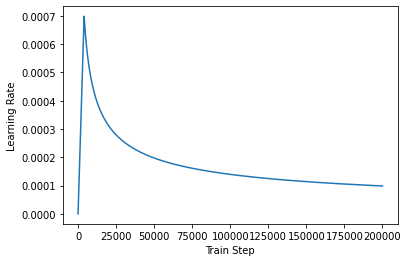

In [37]:
#시각화
sample_learning_rate = CustomSchedule(d_model=512)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 4. 모델 컴파일

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


#### 5. 훈련하기

총 20 에포크를 학습합니다.

In [39]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 110s 477ms/step - loss: 1.4520 - accuracy: 0.0163
Epoch 2/50
185/185 [==============================] - 89s 480ms/step - loss: 1.1109 - accuracy: 0.0494
Epoch 3/50
185/185 [==============================] - 89s 482ms/step - loss: 0.9818 - accuracy: 0.0504
Epoch 4/50
185/185 [==============================] - 89s 482ms/step - loss: 0.9401 - accuracy: 0.0527
Epoch 5/50
185/185 [==============================] - 89s 483ms/step - loss: 0.9023 - accuracy: 0.0549
Epoch 6/50
185/185 [==============================] - 89s 482ms/step - loss: 0.8551 - accuracy: 0.0568
Epoch 7/50
185/185 [==============================] - 89s 483ms/step - loss: 0.8219 - accuracy: 0.0598
Epoch 8/50
185/185 [==============================] - 90s 485ms/step - loss: 0.7680 - accuracy: 0.0635
Epoch 9/50
185/185 [==============================] - 89s 483ms/step - loss: 0.6991 - accuracy: 0.0683
Epoch 10/50
185/185 [==============================] - 89s 483ms/step - 

100에폭도 진행해봤으나 30에폭이후 정확도 향상이 0.1677정도에서 아주 미세하게 상승했다.   
그래서 모델의 적층수 증가(6)와 dmodel을 512 (논문 참조량) 만큼 늘리고 뒤쪽의 정확도 향상이 없으니 50에폭 정도로 줄여 봤다.   
파라메터는 6배 정도 증가하였지만 변화량을 지켜볼 계획이다

## 15-13. 챗봇 테스트하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

    새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
    입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
    패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
    디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
    디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
    END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [40]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [47]:
sentence_generation('밥사')

입력 : 밥사
출력 : 짜증날 땐 짜장면


'짜증날 땐 짜장면'

In [55]:
sentence_generation("노래 불러줘")

입력 : 노래 불러줘
출력 : 저도 좋은 사람 되길 바랄게요 .


'저도 좋은 사람 되길 바랄게요 .'

In [50]:
sentence_generation("이름이 뭐니")

입력 : 이름이 뭐니
출력 : 위로봇이요 .


'위로봇이요 .'

In [51]:
sentence_generation("날씨 좋다")

입력 : 날씨 좋다
출력 : 달콤한 말이네요 .


'달콤한 말이네요 .'

In [53]:
sentence_generation("ㅠㅠ")#인성 파탄 봇이 만들어졌다

입력 : ㅠㅠ
출력 : 기분 좋겠어요 .


'기분 좋겠어요 .'

In [54]:
sentence_generation("위로해줘")

입력 : 위로해줘
출력 : 제가 위로가 되어 드릴게요 .


'제가 위로가 되어 드릴게요 .'

20에폭후 표현이 좀 이상하다 100에폭을 돌려보자
50에폭에 레이어 4개추가 향상시켰지만 여전히 나사가 하나 빠져있다 그래도 종종 맞는 소릴한다   
맨 마지막에 .으로 종종 마무리하는게 그런 마침표도 학습이 잘되는구나 싶다.

## 15-14. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.
Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

[data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

Cloud shell에서 아래 명령어를 입력해 주세요.



Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.   
Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.   
Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.   
Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [44]:
#! mkdir -p ~/aiffel/transformer_chatbot/data/
#! ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

No.|평가문항|	상세기준
-|:-|:-
1.| 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.
2.| 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|	구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.
3.| 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|	한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.

## 회고
음 인코딩 디코딩 트랜스포머 lstm 다양한 방법이 있고 어떻게 혼용해서 써야할지 어떤게 좋은건지   
학습이 실패하면 어디서 손을 봐야할지 잘모르겠지만 일단 말은 하는군요   
나중에 다시 공부겸 이 문서를 돌아 봤을때 저 자신이 알고 있으면 좋겠네요(힘내라 미래의 나)